This file is an implementation of four filters for searching for NFT wash trading for a collection in the TON blockchain using the Telegram usernames as an example.

This code has a lot of room for improvement and is simple, not an efficient or 100% accurate implementation - improve as you see fit.

Since the collection of telegram usernames is large, I saved the main milestones for convenience at 24082023, however, you can upload the data as you like

TBD

In [ ]:
#Install Dependecies
import requests
import string
import pandas as pd
import numpy as np

from tqdm import tqdm

To obtain data, we will use an indexer. The amount of data that we will take in each request, I determined empirically - if you take more, then there will be an error

In [ ]:
endpoint = 'https://dton.io/graphql/'

*   The first thing we will do is get all transactions for the collection we have chosen.
*   If you don't want to wait a few hours, there are pre-prepared data below TBD pre data

In [ ]:
#more than 4 hours

res_arr=[]


def get_txes(res_arr):
  page = 0
  maxPageSize = 150
  blockLimit = 100

  while(True):
    # Collect query by hundreds
    formatted_query =""
    for i in range(page,page+10):
      #print(i)
      template = string.Template("""
        q${page}: transactions(
          parsed_seller_is_closed: 1
          account_state_state_init_code_has_get_nft_data: 1
          workchain: 0
          page: ${page}
          page_size: 10
          parsed_nft_collection_address_address: "80D78A35F955A14B679FAA887FF4CD5BFC0F43B4A4EEA2A7E6927F3701B273C2"
        ) {
          prev_owner: parsed_seller_nft_prev_owner_address_address
          new_owner: parsed_seller_nft_new_owner_address_address
          nft_address: address
          col_address: parsed_nft_collection_address_address
          price: parsed_seller_nft_price
        }
        """)

      formatted = template.substitute(page=i)
      formatted = formatted +"\n"
      formatted_query += formatted

    formatted_query = """query {"""+formatted_query+"""}"""
    #print(formatted_query)
    while True:
      try:
        response = requests.post(endpoint, json={'query': formatted_query})
        print("Status",response.status_code)
        # 40 seconds
        print(page)
        for k,v in response.json()['data'].items():
            #if not v:
            #  break
          # print(type(v))
          if not v:
            print('Done')
            return
          for item in v:
            res_arr.append(item)

        break
      except Exception:
        continue


    # Loop through if empty break



    #if(page > 1200):
      #break



    page = page+10

get_txes(res_arr)

In [ ]:
'''
#write your result to csv
import csv

keys = res_arr[0].keys()

with open('24082023tgnames.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(res_arr)
'''


In [ ]:
import csv


with open('/content/24082023tgnames.csv', "r") as f:
    reader = csv.DictReader(f)
    res_arr = list(reader)

Total Sales:

In [ ]:
# If you decide to use the data prepared by me, then there should be 109158 rows
total_sales_count = len(res_arr)

total_volume = 0
for item in tqdm(res_arr):
  total_volume = total_volume + int(item['price'])/1000000000

total_volume = round(total_volume)

print("\nTotal Sales: ",total_sales_count)
print("\nTotal Volume: ",total_volume," TON")

100%|██████████| 109158/109158 [00:00<00:00, 2181643.26it/s]


Total Sales:  109158

Total Volume:  57143316  TON


1) Filter 1: Buyer = Seller

In [ ]:
counter=0
same_arr=[]
bs_volume = 0

for pair in tqdm(res_arr):
  if(pair['prev_owner'] == pair['new_owner'] and pair['prev_owner'] is not None and pair['new_owner'] is not None):
    #print(pair['nft_address'],int(pair['price']))
    counter = counter + 1
    bs_volume = bs_volume + int(pair['price'])/1000000000
    same_arr.append(pair)


bs_volume = round(bs_volume)
print("\nBuyer = Seller Sales: ",counter)
print("\nPercentage from Total Sales: ",round((counter/total_sales_count)*100,2),"%")
print("\nBuyer = Seller Volume: ",bs_volume," TON")
print("\nPercentage from Total Sales: ",round((bs_volume/total_volume)*100,2),"%")

100%|██████████| 109158/109158 [00:00<00:00, 2891017.93it/s]


Buyer = Seller Sales:  1562

Percentage from Total Sales:  1.43 %

Buyer = Seller Volume:  333267  TON

Percentage from Total Sales:  0.58 %


Example of such trades:

*   https://tonscan.org/address/EQA6MQLzd6yo1eFbKDZqwNn9XfODn-c2Xv9CLtI93eeuP7_O
*   or for simplicity https://getgems.io/nft/EQA6MQLzd6yo1eFbKDZqwNn9XfODn-c2Xv9CLtI93eeuP7_O



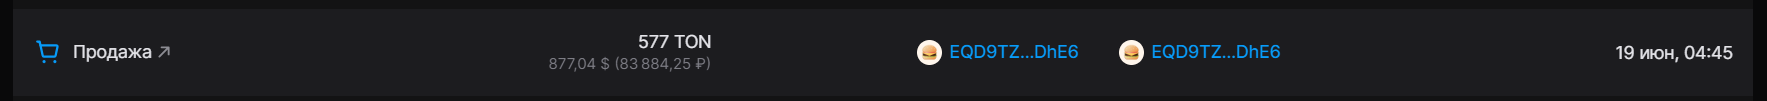

or https://getgems.io/nft/EQCQLbJE0Qx1OBUBUSsokESFg5xrWfFvfEIZ6hQJUMuLQmQK

One of the most common wash trading strategies has been to trade the same NFT between two different wallets, sending it back and forth.

2) Back & Forth Trades

In [ ]:
bs_arr=[]
bs_counter = 0

for pair in tqdm(res_arr):
  #pair[nft_address]
  for reverse_pair in res_arr:
    if(pair['prev_owner'] == reverse_pair['new_owner'] and pair['new_owner'] == reverse_pair['prev_owner'] and pair['prev_owner'] is not None and pair['new_owner'] is not None and pair['prev_owner'] != pair['new_owner'] and pair['nft_address'] == reverse_pair['nft_address']):
      bs_arr.append(pair)
      bs_counter = bs_counter + 1


print(bs_counter)

In [ ]:
bf_arr=[]

with open('/content/24082023tgnamesMirrors.csv', "r") as f:
    reader = csv.DictReader(f)
    bf_arr = list(reader)

In [ ]:
len(bf_arr)

rev_bf_arr=[]

for pair in tqdm(res_arr):
  for rev_pair in bf_arr:
    if(rev_pair['prev_owner'] == pair['new_owner'] and rev_pair['new_owner'] == pair['prev_owner'] and pair['prev_owner'] is not None and pair['new_owner'] is not None and pair['prev_owner'] != pair['new_owner'] and pair['nft_address'] == rev_pair['nft_address']):
      rev_bf_arr.append(pair)

100%|██████████| 109158/109158 [00:01<00:00, 81557.29it/s]


In [ ]:
rev_bf_arr.extend(bf_arr)


In [ ]:
rev_bf_counter = len(rev_bf_arr)

rev_bf_volume = 0

for pair in tqdm(rev_bf_arr):
  rev_bf_volume = rev_bf_volume + int(pair['price'])/1000000000



rev_bf_volume = round(rev_bf_volume)
print("\nBack and Forth Sales: ",rev_bf_counter)
print("\nPercentage from Total Sales: ",round((rev_bf_counter/total_sales_count)*100,2),"%")
print("\nBack and Forth Volume: ",rev_bf_volume," TON")
print("\nPercentage from Total Sales: ",round((rev_bf_volume/total_volume)*100,2),"%")

100%|██████████| 366/366 [00:00<00:00, 818291.72it/s]


Back and Forth Sales:  366

Percentage from Total Sales:  0.34 %

Back and Forth Volume:  96275  TON

Percentage from Total Sales:  0.17 %


Example of such trades:

*   https://tonscan.org/address/EQBwqLB8jJSClGFLvi5SJGPpx-N7oFIO-RReOecdCRPM2AYu
*   or for simplicity https://getgems.io/nft/EQBwqLB8jJSClGFLvi5SJGPpx-N7oFIO-RReOecdCRPM2AYu




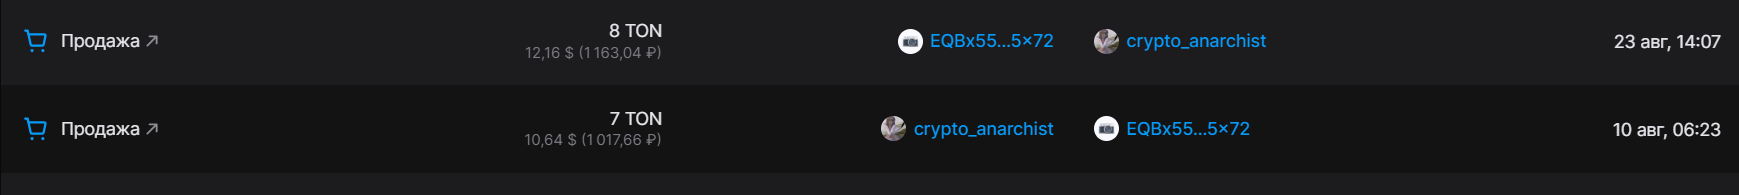

In [ ]:
'''
keys = bs_arr[0].keys()

with open('24082023tgnamesMirrors.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(bs_arr)
'''

Filter 3: Bought NFTs 3x times

In [ ]:
# remove all nft from the previous steps without reverse transactions so that they do not knock out too much

In [ ]:
clean_arr=res_arr
len(clean_arr)

109158

In [ ]:
same_arr_temp = same_arr
print(len(same_arr_temp))
same_arr_temp.extend(bf_arr)

1562


In [ ]:
len(same_arr_temp)

1726

In [ ]:
for item in tqdm(res_arr):
  for cl in same_arr_temp:
    if item == cl:
        clean_arr.remove(item)
        break

 99%|█████████▊| 107625/109158 [00:30<00:00, 3578.55it/s]


In [ ]:
len(clean_arr)

107625

In [ ]:
df_clean = pd.DataFrame.from_records(clean_arr)

In [ ]:
df_clean.shape

(107625, 5)

In [ ]:
df_counter = df_clean.groupby(["prev_owner", "nft_address"]).size().reset_index(name="Counter").sort_values(by=['Counter'])

In [ ]:
df_morethan = df_counter.loc[df_counter['Counter'] > 3]

In [ ]:
df_morethan.shape

(69, 3)

In [ ]:
threetime_arr=df_morethan.to_dict('records')

Let's count the number of such transactions in a cycle and collect the necessary information

In [ ]:
three_counter = 0
three_volume = 0

for item in tqdm(clean_arr):
  for cl in threetime_arr:
    if(item["prev_owner"] == cl["prev_owner"] and item["nft_address"] == cl["nft_address"]):
      three_volume = three_volume + int(pair['price'])/1000000000
      three_counter = three_counter + 1


three_volume = round(three_volume)
print("\nThree times owned Sales: ",three_counter)
print("\nPercentage from Total Sales: ",round((three_counter/total_sales_count)*100,2),"%")
print("\nThree times owned Volume: ",three_volume," TON")
print("\nPercentage from Total Sales: ",round((three_volume/total_volume)*100,2),"%")

100%|██████████| 107625/107625 [00:00<00:00, 156612.31it/s]


Three times owned Sales:  307

Percentage from Total Sales:  0.28 %

Three times owned Volume:  3676  TON

Percentage from Total Sales:  0.01 %


Example of such trades:

*   https://tonscan.org/address/EQBojNunoLV_6V6R8tCddgo9I-g0h4TerAUcZpSf1tin9xC6
*   or for simplicity https://getgems.io/nft/EQBojNunoLV_6V6R8tCddgo9I-g0h4TerAUcZpSf1tin9xC6

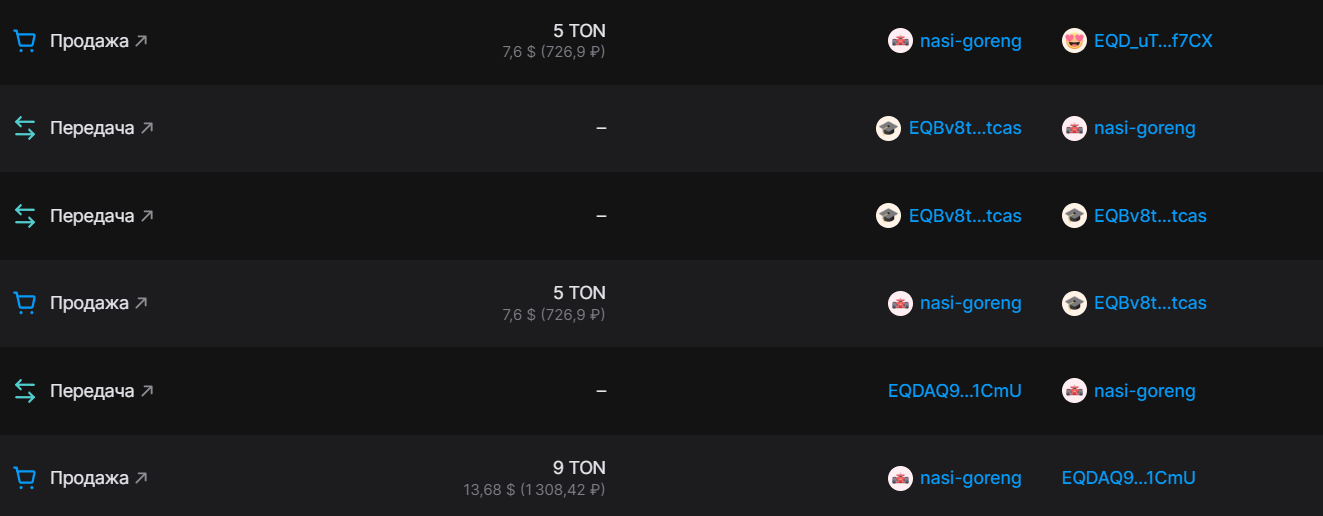

In [ ]:
clean3_arr=clean_arr.copy()

In [ ]:
for item in tqdm(clean_arr):
  for cl in threetime_arr:
    if(item["prev_owner"] == cl["prev_owner"] and item["nft_address"] == cl["nft_address"]):
        clean3_arr.remove(item)

100%|██████████| 107625/107625 [00:01<00:00, 95560.28it/s] 


In [ ]:
len(clean3_arr)

107318

Filter 4. Buyer & Seller First Funded by Same Wallet

In [ ]:
# уникальные адреса
# собираем кол-во транзакции
# достаем первые траназакции IN


Take all unique from columns prev and new owner to make dictionary of


In [ ]:
new_owner_unique = set(d['new_owner'] for d in clean3_arr)
prev_owner_unique = set(d['prev_owner'] for d in clean3_arr)

In [ ]:
unique_address = new_owner_unique  | prev_owner_unique

In [ ]:
len(unique_address)

81666

In [ ]:
unique_address=list(unique_address)

In [ ]:
n = 150

# Generator comprehension
chunks = list(unique_address[i:i + n] for i in range(0, len(unique_address), n))

In [ ]:
temp_catalog=[]

for chunk in tqdm(chunks):
  formatted_query =""
  for count, value in enumerate(chunk):
        template = string.Template("""
          q${value}: accountTransactionCount(address: "${value}", workchain: 0)
        """)

        formatted = template.substitute(count=count,value=value)
        formatted = formatted +"\n"
        formatted_query += formatted

  formatted_query = """query {"""+formatted_query+"""}"""
  #print(formatted_query)
  response = requests.post(endpoint, json={'query': formatted_query})
  if response.status_code == 200:
    #print(response.status_code)
    for k,v in response.json()['data'].items():
      temp = {'addr': k[1:], 'txescount': v}
      temp_catalog.append(temp)
      #print(k[1:],v)
  else:
    print(response.status_code)

100%|██████████| 545/545 [1:03:44<00:00,  7.02s/it]


In [ ]:
len(temp_catalog)

NameError: ignored

In [ ]:
'''
import csv

keys = temp_catalog[0].keys()

with open('24082023txestemp.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(temp_catalog)

'''

In [ ]:
temp_catalog=[]

with open('/content/24082023txestemp.csv', "r") as f:
    reader = csv.DictReader(f)
    temp_catalog = list(reader)

In [ ]:
temp_catalog[0]['txescount']

In [ ]:
temp_catalog[10]

In [ ]:
df_check = pd.DataFrame.from_records(temp_catalog)

In [ ]:
df_check['txescount'].value_counts().sort_values()

In [ ]:
y = 100

# Generator comprehension
chunks_temp = list(temp_catalog[i:i + y] for i in range(0, len(temp_catalog), y))

In [ ]:
catalog=[]

for chunk in tqdm(chunks_temp):
  formatted_query =""
  for count, value in enumerate(chunk):
        template = string.Template("""
          q${value}: transactions(
            address: "${value}"
            page: 0
            page_size: 1
            workchain: 0
            order_by: "gen_utime"
            order_desc: false
          ) {
            in_msg_src_addr_address_hex
          }
        """)

        formatted = template.substitute(value=value['addr'],pg=int(value['txescount'])-1)
        #print(formatted)
        formatted = formatted +"\n"
        formatted_query += formatted

  formatted_query = """query {"""+formatted_query+"""}"""
  #print(formatted_query)
  response = requests.post(endpoint, json={'query': formatted_query})
  if response.status_code == 200:
    #print(response.status_code)
    #print(response.json()['data'])
    for k,v in response.json()['data'].items():
      #temp = {'addr': k[1:], 'first_inaddr': v[0]['in_msg_src_addr_address_hex']}
      #catalog.append(temp)
      #print(k,v)
      try:
        temp = {'addr': k[1:], 'first_inaddr': v[0]['in_msg_src_addr_address_hex']}
        catalog.append(temp)
      except Exception:
        pass
  else:
    print(response.status_code)
    print(chunk)


100%|██████████| 817/817 [1:51:56<00:00,  8.22s/it]


81652

In [ ]:
keys = catalog[0].keys()

with open('24082023catalog.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(catalog)

In [ ]:

catalog=[]

with open('/content/24082023catalog.csv', "r") as f:
    reader = csv.DictReader(f)
    catalog = list(reader)

In [ ]:
len(catalog)

81652

In [ ]:
catalog[0]

{'addr': '1AC1DD6633EA9512DDC1131E0192A772D0BC9DA3B8DDB0D70BD202615A70F72F',
 'first_inaddr': '7DA5E125A2B97E291245494F2DF705F089F6597FC367F94604310793471BE846'}

In [ ]:
# d['mynewkey'] = 'mynewvalue' Добавляем две колонки

for row in tqdm(clean3_arr):
  for item in catalog:
    if(item['addr'] == row['prev_owner']):
      row['prev_owner_first_funded'] = item['first_inaddr']
    #else:
    #  row['prev_owner_first_funded'] = None
    if(item['addr'] == row['new_owner']):
      row['new_owner_first_funded'] = item['first_inaddr']
    #else:
    #  row['new_owner_first_funded'] = None

100%|██████████| 107318/107318 [56:05<00:00, 31.89it/s]


In [ ]:
keys = clean3_arr[0].keys()

with open('24082023firstfunded.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(clean3_arr)

In [ ]:
enriched=[]

import csv

with open('/content/24082023firstfunded.csv', "r") as f:
    reader = csv.DictReader(f)
    enriched = list(reader)

In [ ]:
enriched[0]

{'prev_owner': '6F9BA4A066759157F194EB2F937F8F40910BEA3CA6555CB22FC25C7A45D28F57',
 'new_owner': '1F5F46F22FB69CCEA9C3ACF73BDB9CCE89014A988732A653FE2A465FFA23394F',
 'nft_address': '7E4900D85A3AEE987D9E2DE004073AD74933FADCDE2C0706A061871E4A81FD7D',
 'col_address': '80D78A35F955A14B679FAA887FF4CD5BFC0F43B4A4EEA2A7E6927F3701B273C2',
 'price': '8947471818',
 'prev_owner_first_funded': '7E4900D85A3AEE987D9E2DE004073AD74933FADCDE2C0706A061871E4A81FD7D',
 'new_owner_first_funded': 'FF915CE6C7A43D553D949B11572E9FE07ACCAC5B5B9FDED37F86A233C2EF21B9'}

In [ ]:
f_counter = 0
f_volume = 0
funded_arr=[]

for pair in tqdm(enriched):
  if(pair['prev_owner_first_funded'] == pair['new_owner_first_funded'] and pair['prev_owner_first_funded'] is not None and pair['new_owner_first_funded'] is not None):
    f_counter = f_counter + 1
    f_volume = f_volume + int(pair['price'])/1000000000
    funded_arr.append(pair)



f_volume = round(f_volume)
print("\nFounded Sales: ",f_counter  )
print("\nPercentage from Total Sales: ",round((f_counter/total_sales_count)*100,2),"%")
print("\nFounded Volume: ",f_volume," TON")
print("\nPercentage from Total Sales: ",round((f_volume/total_volume)*100,2),"%")


100%|██████████| 107318/107318 [00:00<00:00, 2423776.15it/s]


Three times owned Sales:  1722

Percentage from Total Sales:  1.58 %

Three times owned Volume:  159462  TON

Percentage from Total Sales:  0.28 %


In [ ]:
'prev_owner': '21521F7BFDD869587D742316E06BD9AB8FDDFE73C198971CA3FAE216B5E9AC1D', https://tonscan.org/address/EQAhUh97_dhpWH10Ixbga9mrj93-c8GYlxyj-uIWtemsHUH_
'new_owner': '4391DCE8865CD261F64FFEC56BEFC9C6A68FE11210CBAA05D9C05AEFE0D03188', https://tonscan.org/address/EQBDkdzohlzSYfZP_sVr78nGpo_hEhDLqgXZwFrv4NAxiNUo
'nft_address': 'D661DDF48742A2EA67945ACD9DCF8BBA7636B280651A0024BBDEF6A9CEBE1039', https://tonscan.org/address/EQDWYd30h0Ki6meUWs2dz4u6djaygGUaACS73vapzr4QOYPU
'col_address': '80D78A35F955A14B679FAA887FF4CD5BFC0F43B4A4EEA2A7E6927F3701B273C2',
  'price': '9980366888',
'prev_owner_first_funded': 'AD8AFECFACC248996885D8BE6824280F9F3A7E54C2F6080B7971B9F556C280C4 https://tonscan.org/address/EQCtiv7PrMJImWiF2L5oJCgPnzp-VML2CAt5cbn1VsKAxLiE
'new_owner_first_funded': 'AD8AFECFACC248996885D8BE6824280F9F3A7E54C2F6080B7971B9F556C280C4' https://tonscan.org/address/EQCtiv7PrMJImWiF2L5oJCgPnzp-VML2CAt5cbn1VsKAxLiE

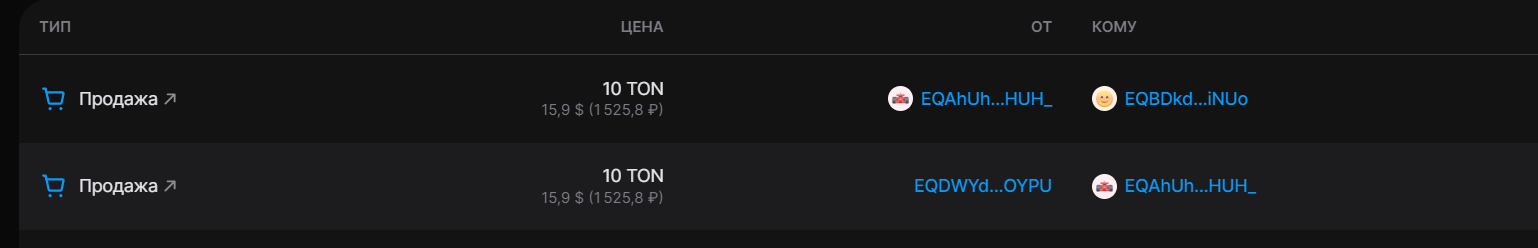

In [ ]:
print("\nBuyer = Seller Sales: ",counter)
print("\nPercentage from Total Sales: ",round((counter/total_sales_count)*100,2),"%")
print("\nBuyer = Seller Volume: ",bs_volume," TON")
print("\nPercentage from Total Sales: ",round((bs_volume/total_volume)*100,2),"%")


Buyer = Seller Sales:  1562

Percentage from Total Sales:  1.43 %

Buyer = Seller Volume:  333267  TON

Percentage from Total Sales:  0.58 %


In [ ]:
print("\nBack and Forth Sales: ",rev_bf_counter)
print("\nPercentage from Total Sales: ",round((rev_bf_counter/total_sales_count)*100,2),"%")
print("\nBack and Forth Volume: ",rev_bf_volume," TON")
print("\nPercentage from Total Sales: ",round((rev_bf_volume/total_volume)*100,2),"%")

In [ ]:
print("\nThree times owned Sales: ",three_counter)
print("\nPercentage from Total Sales: ",round((three_counter/total_sales_count)*100,2),"%")
print("\nThree times owned Volume: ",three_volume," TON")
print("\nPercentage from Total Sales: ",round((three_volume/total_volume)*100,2),"%")

In [ ]:
print("\nThree times owned Sales: ",f_counter  )
print("\nPercentage from Total Sales: ",round((f_counter/total_sales_count)*100,2),"%")
print("\nThree times owned Volume: ",f_volume," TON")
print("\nPercentage from Total Sales: ",round((f_volume/total_volume)*100,2),"%")

In [ ]:
wash_counter = counter+rev_bf_counter+three_counter+f_counter
print("\nWash Sales: ",wash_counter)
print("\nPercentage from Total Sales: ",round((wash_counter/total_sales_count)*100,2),"%")
wash_volume = bs_volume + rev_bf_volume + three_volume + f_volume
print("\nWash Volume: ",wash_volume," TON")
print("\nPercentage from Total Sales: ",round((wash_volume/total_volume)*100,2),"%")


Wash Sales:  3957

Percentage from Total Sales:  3.63 %

Wash Volume:  592680  TON

Percentage from Total Sales:  1.04 %
